<a href="https://www.kaggle.com/code/waitongchung/smallhit-tfmultigpu?scriptVersionId=118713290" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This BLASTNet Tutorial is written by Wai Tong Chung. More info visit https://blastnet.github.io

This Python 3 environment comes with many helpful analytics libraries installed
It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

Input data files are available in the read-only "../input/" directory
For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 

You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Citations

Please cite the following when publishing based on this dataset:

1. Appl. Energy in Combust. Sci. Paper: https://doi.org/10.1016/j.jaecs.2022.100087
2. ICML W. Paper: https://openreview.net/forum?id=LxGTZM7L6qn
3. Dataset citation: https://doi.org/10.5281/zenodo.7242864


# Intro

In this tutorial, we'll be performing a **regression** exercise with a CNN on a turbulence problem.

To quote Werner Heisenberg:
>  **"When I meet God, I am going to ask him two questions: Why relativity? And why turbulence? I really believe he will have an answer for the first."**

Specifically for who understand turbulence, it will be an exercise to predict the subgrid-scale stresses from downsampled fluid direct numerical simulation data.

For newcomers, https://en.wikipedia.org/wiki/Turbulence_modeling provides a high level intro to this problem. In essence, turbulence modeling recovers missing physics when performing simulations on a resolution that's too blurry to capture all the relevant physical information. In essence, it's a old-school algebraic super-resolution (https://en.wikipedia.org/wiki/Super-resolution_imaging) approach.
LES (https://en.wikipedia.org/wiki/Large_eddy_simulation) is one such approach.

But it's enough to consider this as a regression problem that **outputs physics from high-resolution simulation methods** with **blurry low-resolution inputs**.

Here, we're training with **multi-GPUs**. Make sure you have **GPU T4x2** set as your accelerator in the Settings in the right-side bar.

# Import libs and set data path

In [1]:
import numpy as np # linear algebra
import json
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.ndimage import gaussian_filter
import time
from tensorflow.python.client import device_lib
import pandas as pd

data_path = '/kaggle/input/'+os.popen('ls '+'/kaggle/input/').read().split('\n')[0]+'/'
print("Data path: ",data_path)

Data path:  /kaggle/input/inert-ch4o2-hit-dns/


Let's check whether you have the correct GPUs set up

In [2]:
#2 GPUs + 1 CPU
if len(device_lib.list_local_devices()) != 2+1:
    print("Make sure you have GPU T4x2 set as your accelerator in the Settings in the right-side bar.")
else:
    print("You have the correct GPUs set up.")


You have the correct GPUs set up.


2023-02-09 21:02:43.266981: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 21:02:43.692533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 21:02:43.693609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 21:02:43.784870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

# Metadata

We first obtain info on this BLASTNet dataset by reading info.json.

In [3]:
f = open(data_path + '/info.json')
metadata = json.load(f) #returns a dict

The metadata is comprised of the global metadata, which provides info on the dataset as a whole:

In [4]:
for key in metadata['global']:
    print(key," : ",metadata['global'][key])

dataset_id  :  waitongchung/inert-ch4o2-hit-dns
Nxyz  :  [129, 129, 129]
snapshots  :  98
variables  :  ['UX_ms-1', 'UY_ms-1', 'UZ_ms-1', 'P_Pa', 'T_K', 'RHO_kgm-3', 'YO2', 'YCH4']
compression  :  None
grid  :  {'x': './grid/X_m.dat', 'y': './grid/Y_m.dat', 'z': './grid/Z_m.dat'}
bc  :  Periodic in x-, y-, and z-directions.
ic  :  {'U': 'HIT Von Karman Pao with Re_t = 80 and integral lengthscale of 62.5E-6m', 'T [K]': 300, 'P [Pa]': 101325, 'Mixture': 'CH4-O2 inert branch from 1D cantera counterflow calculations.'}
doi  :  https://doi.org/10.1016/j.combustflame.2021.111758
contributors  :  Wai Tong Chung and Matthias Ihme
description  :  Compressible Inert CH4-O2 Homogeneous Isotropic Turbulence DNS
chem_thermo_tran  :  {'cantera_xml': './chem_thermo_tran/bfer.xml'}


And the local metadata which provides info on the individual snapshots. Here, we print some local metadata.

In [5]:
if len(metadata['local'])>3:
    for file_id in range(3):
        for key in metadata['local'][file_id]:
            print(key," : ",metadata['local'][file_id][key])
        print("----------------------------------")
else:
    file_id = 0
    for key in metadata['local'][file_id]:
        print(key," : ",metadata['local'][file_id][key])



id  :  0
time [s]  :  3.08296e-07
UX_ms-1 filename  :  ./data/UX_ms-1_id000.dat
UY_ms-1 filename  :  ./data/UY_ms-1_id000.dat
UZ_ms-1 filename  :  ./data/UZ_ms-1_id000.dat
P_Pa filename  :  ./data/P_Pa_id000.dat
T_K filename  :  ./data/T_K_id000.dat
RHO_kgm-3 filename  :  ./data/RHO_kgm-3_id000.dat
YO2 filename  :  ./data/YO2_id000.dat
YCH4 filename  :  ./data/YCH4_id000.dat
----------------------------------
id  :  1
time [s]  :  6.23745e-07
UX_ms-1 filename  :  ./data/UX_ms-1_id001.dat
UY_ms-1 filename  :  ./data/UY_ms-1_id001.dat
UZ_ms-1 filename  :  ./data/UZ_ms-1_id001.dat
P_Pa filename  :  ./data/P_Pa_id001.dat
T_K filename  :  ./data/T_K_id001.dat
RHO_kgm-3 filename  :  ./data/RHO_kgm-3_id001.dat
YO2 filename  :  ./data/YO2_id001.dat
YCH4 filename  :  ./data/YCH4_id001.dat
----------------------------------
id  :  2
time [s]  :  9.43542e-07
UX_ms-1 filename  :  ./data/UX_ms-1_id002.dat
UY_ms-1 filename  :  ./data/UY_ms-1_id002.dat
UZ_ms-1 filename  :  ./data/UZ_ms-1_id002.dat
P_

# Grid Information

Since we're dealing with spatial data let's look at the spatial grid. We first get some details from the metadata.

In [6]:
Nx,Ny,Nz = metadata['global']['Nxyz']

X_filename = metadata['global']['grid']['x']
Y_filename = metadata['global']['grid']['y']
Z_filename = metadata['global']['grid']['z']

print(X_filename)
print(Y_filename)
print(Z_filename)

./grid/X_m.dat
./grid/Y_m.dat
./grid/Z_m.dat


Now lets load the 3D grid data and obtain their 1D profiles

In [7]:
#load data
X =  np.fromfile(data_path+X_filename,dtype='<f4')
Y =  np.fromfile(data_path+Y_filename,dtype='<f4')
Z =  np.fromfile(data_path+Z_filename,dtype='<f4')

#get 1d profile
x1d = np.unique(X)
y1d = np.unique(Y)
z1d = np.unique(Z)

# Creating Features, Labels, and a Data Loader

Here are some tools that we will need for constructing our features X and labels Y. In this turbulence modeling exercise, we:
1. Apply a filter that blurs our 3D data.
2. Downsample the all relevant arrays.

This creates our features, *i.e.*, our low-resolution simulation data.

3. We create our labels, 6 components of the subgrid-scale stresses.

These 6 labels are the missing physics when missing physics when simulating with low-resolution grids.

To do this, let's get some helper functions that can do all of this, and construct our features and labels for this problem. We also want a function for sampling from our dataset.

In [8]:
#This blurs and downsamples our data
def my_gauss_filter(phi,fw):
    return gaussian_filter(phi,fw)[int(fw/2)::fw,int(fw/2)::fw,int(fw/2)::fw]

#This is a wrapper for blurring and downsampling our data in a physically consistent fashion.
#Search up 'favre filter' in https://en.wikipedia.org/wiki/Large_eddy_simulation.
def my_favre_filter(phi,rho,fw,type):
    if type == 'gauss':
        return my_gauss_filter(rho*phi,fw)/my_gauss_filter(rho,fw)

#This constructs our features and labels
def getXYsgs3d(rho,ux,uy,uz):
    #features: 3 filtered velocty downsampled by 4x
    ux_filter = my_favre_filter(ux,rho,4,'gauss')
    uy_filter = my_favre_filter(uy,rho,4,'gauss')
    uz_filter = my_favre_filter(uz,rho,4,'gauss')
    
    #features: 6 components of the subgrid-scale stress downsampled by 4x
    tau11_rho = my_favre_filter(ux*ux,rho,4,'gauss') - ux_filter*ux_filter
    tau12_rho = my_favre_filter(ux*uy,rho,4,'gauss') - ux_filter*uy_filter
    tau13_rho = my_favre_filter(ux*uz,rho,4,'gauss') - ux_filter*uz_filter
    tau22_rho = my_favre_filter(uy*uy,rho,4,'gauss') - uy_filter*uy_filter
    tau23_rho = my_favre_filter(uy*uz,rho,4,'gauss') - uy_filter*uz_filter
    tau33_rho = my_favre_filter(uz*uz,rho,4,'gauss') - uz_filter*uz_filter
    
    #convert to tensorflow tensors 
    X = tf.stack([ux_filter,uy_filter,uz_filter],axis=3)
    Y = tf.stack([tau11_rho,tau12_rho,tau13_rho,tau22_rho,tau23_rho,tau33_rho],axis=3)
    return [X,Y]

#Samples data with an index or file id (int)
def load_single_sample(idx):
    ux_path = data_path + metadata['local'][idx]['UX_ms-1 filename']
    uy_path = data_path + metadata['local'][idx]['UY_ms-1 filename']
    uz_path = data_path + metadata['local'][idx]['UZ_ms-1 filename']
    rho_path = data_path + metadata['local'][idx]['RHO_kgm-3 filename']
    ux = np.fromfile(ux_path,dtype='<f4').reshape(Nx,Ny,Nz)[:-1,:-1,:-1]
    uy = np.fromfile(uy_path,dtype='<f4').reshape(Nx,Ny,Nz)[:-1,:-1,:-1]
    uz = np.fromfile(uz_path,dtype='<f4').reshape(Nx,Ny,Nz)[:-1,:-1,:-1]
    rho = np.fromfile(rho_path,dtype='<f4').reshape(Nx,Ny,Nz)[:-1,:-1,:-1]
    return getXYsgs3d(rho,ux,uy,uz)

Now let's try the functions we've written by sampling a data with it's id.

In [9]:
my_id = 10
print("Sample info:")
print(metadata['local'][my_id])
X0,Y0 = load_single_sample(my_id)

Sample info:
{'id': 10, 'time [s]': 3.55113e-06, 'UX_ms-1 filename': './data/UX_ms-1_id010.dat', 'UY_ms-1 filename': './data/UY_ms-1_id010.dat', 'UZ_ms-1 filename': './data/UZ_ms-1_id010.dat', 'P_Pa filename': './data/P_Pa_id010.dat', 'T_K filename': './data/T_K_id010.dat', 'RHO_kgm-3 filename': './data/RHO_kgm-3_id010.dat', 'YO2 filename': './data/YO2_id010.dat', 'YCH4 filename': './data/YCH4_id010.dat'}


2023-02-09 21:02:51.090731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 21:02:51.091842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 21:02:51.092709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 21:02:51.093502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 21:02:51.094267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Now let's get some info about our feature and label tensors. Note that after downsamping, the volume is now 32<sup>3</sup>. The 4th dimensions is the CNN channel for 3 velocities and 6 subgrid-scale stresses, for features and labels, respectively.

In [10]:
print("Feature shapes:")
print( X0.shape)
print("Label shapes:")
print( Y0.shape)

nx_in, ny_in, nz_in, nc_in = X0.shape
nx_out, ny_out, nz_out, nc_out = Y0.shape

Feature shapes:
(32, 32, 32, 3)
Label shapes:
(32, 32, 32, 6)


We can now visualize the 3 channels of our features. 
We can convert tensorflow tensors to numpy arrays with the numpy() function. 

Text(0.5, 0.04, 'z index')

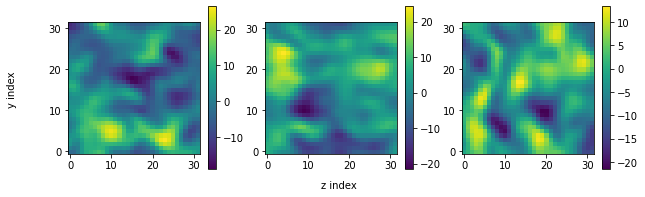

In [11]:
figsize = np.array((10, 3))

fig, axs = plt.subplots(1,nc_in,figsize=figsize)

for c in range(nc_in):
    im = axs[c].imshow(X0.numpy()[int(nx_in/2),:,:,c].T,origin='lower')
    plt.colorbar(im, ax=axs[c])
    
fig.text(0.04, 0.5, 'y index', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'z index', ha='center')

Repeat for labels

Text(0.5, 0.04, 'z index')

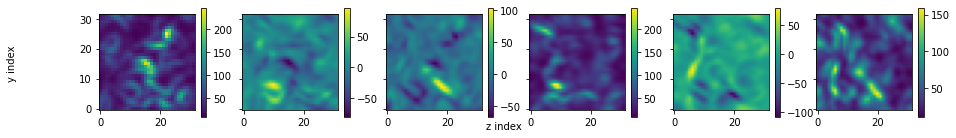

In [12]:
figsize = np.array((15, 2))

fig, axs = plt.subplots(1,nc_out,figsize=figsize,sharex=True,sharey=True)

for c in range(nc_out):
    im = axs[c].imshow(Y0.numpy()[int(nx_in/2),:,:,c].T,origin='lower')
    plt.colorbar(im, ax=axs[c])
    
fig.text(0.04, 0.5, 'y index', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'z index', ha='center')

# Creating a Tensorflow Dataset

Now that we have a function that can give us features and labels. We can use the tensorflow Dataset object to build an efficient data pipeline.

Since most GPUs have about ~16GB of memory limit. 3D arrays can be challenging especially when training with TB-scale data from https://blastnet.github.io/

So, we'll be storing the file ids in memory instead and using map functions to sample data during training.

In [13]:
nfile = len(metadata['local'])
all_idx = np.arange(nfile)
print("File IDs: ")
print(all_idx)

File IDs: 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98]


To load the create a tensorflow Dataset object that samples features and labels when given a list of IDs, we have to have a tensorflow wrapper function: 

In [14]:
def load_dataset_wrapper(file_idx):
    return tf.py_function(load_single_sample, inp=[file_idx], Tout=[tf.float32,tf.float32])

Now we can create a dataset object as follows. num_parallel_calls allows for parallel operations with your computer.

In [15]:
all_ds = tf.data.Dataset.from_tensor_slices(all_idx)
all_ds = all_ds.map(load_dataset_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

You can use this approach for all the data-preprocessing steps such as shuffling, batching, scaling, and other data augmentation steps that are needed to train models effectively.

More on data augmentation: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Doing this will result in:

In [16]:
#scale labels and features
def scale_tf(X,Y):
    Xscaled = (X-minX)/(maxX - minX)
    Yscaled = (Y-minY)/(maxY - minY)
    return (Xscaled,Yscaled)

#tensorflow wrapper
def scale_wrapper(X,Y):
    return tf.py_function(scale_tf, inp=[X,Y], Tout=[tf.float32,tf.float32])

#Get min and max for scaling
X0,Y0 = load_single_sample(0)
maxX = tf.math.reduce_max(X0)
minX = tf.math.reduce_min(X0)
maxY = tf.math.reduce_max(Y0)
minY = tf.math.reduce_min(Y0)
print(np.array([maxX,minX,maxY,minY]))


#Create dataset object
batch_size = 2 #must be divisible by number of GPUs
nepochs = 1
all_ds = tf.data.Dataset.from_tensor_slices(all_idx)
all_ds = (all_ds
    .shuffle(nfile)
    .repeat(nepochs)
    .map(load_dataset_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .map(scale_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
)

[  47.69044  -49.12168  527.8102  -224.76889]


all_ds looks more complete now but needs to be optimized for faster IO performance (https://www.tensorflow.org/guide/data_performance). Beware of caching though, as some memory management is needed when using this:

In [17]:
all_ds = tf.data.Dataset.from_tensor_slices(all_idx)
all_ds = (all_ds
    .shuffle(nfile)
    .repeat(nepochs)
    .map(load_dataset_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .map(scale_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

We compare the two approaches in the next section

# Benchmarking Pipelines

Here, we benchmark our two data loaders. But note that the current dataset could be faster if the feature and label creation was done beforehand and stored separately, not when loading data. However, for simplicity of this tutorial and limitations in storing outputs in Kaggle, we leave this to the reader to do this when training on their own computers. 

We first write some code to benchmark the IO performance of our data pipeline

In [18]:
def benchmark(dataset, num_epochs=1):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)

To save time, lets use a small Dataset with 3 IDs, and benchmark IO:

In [19]:
small_ds = tf.data.Dataset.from_tensor_slices(range(3))
small_ds = (small_ds
    .shuffle(3)
    .repeat(nepochs)
    .map(load_dataset_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .map(scale_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
)

benchmark(small_ds,3)

2023-02-09 21:02:58.224213: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Execution time: 23.957544571000085


Repeat with caching and prefetching. Note the time saved:

In [20]:
small_ds = tf.data.Dataset.from_tensor_slices(range(3))
small_ds = (small_ds
    .shuffle(3) #shuffles the data
    .repeat(nepochs) #repeat shuffling at each epoch
    .map(load_dataset_wrapper, num_parallel_calls=tf.data.AUTOTUNE) #load data
    .cache() #cache loaded data for each epoch
    .map(scale_wrapper, num_parallel_calls=tf.data.AUTOTUNE) #scales
    .batch(batch_size) #batches the data for batch training
    .prefetch(tf.data.AUTOTUNE) #makes sure that 1 batch is ready before training
)

benchmark(small_ds,3)

Execution time: 6.91984745000002


# Create a CNN model

Here we'll be implementing a 3D ResNet-like autoencoder used in one of my previous studies (More info: https://doi.org/10.1016/j.jaecs.2022.100087)

![Img](https://blastnet.github.io/assets/img/modelArch_kaggle.png)

We first need to define the layers with a function:

In [21]:
def build_autoencoder(input_shape=(32,32,32, 3),C_chan = 8,C_mult = [2, 2, 1]):
    #encoder
    encoder_input = tf.keras.Input(shape=input_shape, name="original_solut")
    C = C_chan
    x = tf.keras.layers.Conv3D(C, 3, activation="relu",padding="same",name='conv_1')(encoder_input)
    skip_connection = x
    for i in range(12):
        B_skip_connection = x
        x = tf.keras.layers.Conv3D(C, 3, activation="relu",padding="same",name ='residual_block_{}a'.format(i))(x)
        x = tf.keras.layers.Conv3D(C, 3, activation=None,padding="same",name ='residual_block_{}b'.format(i))(x)
        x = tf.keras.layers.add([x, B_skip_connection])
    x = tf.keras.layers.Conv3D(C, 3, activation="relu",padding="same",name ='conv_2'.format(i))(x)
    x = tf.keras.layers.add([x, skip_connection])

    for i in range(3):
        C = int(x.get_shape()[-1])
        x = tf.keras.layers.Conv3D(C, 3, strides = [2,2,2], activation=tf.keras.layers.LeakyReLU(alpha=0.2),padding="same",
                               name ='c_block_{}a'.format(i))(x)
        x = tf.keras.layers.Conv3D(C_mult[i]*C, 3, activation=tf.keras.layers.LeakyReLU(alpha=0.2),padding="same",
                               name ='compress_block_{}b'.format(i))(x)

    C = int(x.get_shape()[-1])
    encoder_output = tf.keras.layers.Conv3D(int(C/2), 3, activation=None,padding="same",
                               name ='conv_out'.format(i))(x)
    encoder = tf.keras.Model(encoder_input, encoder_output, name="encoder")

    decoder_input = tf.keras.Input(shape=encoder_output.shape[1:], name="encoded_solut")
    C = decoder_input.shape[-1]
    x = tf.keras.layers.Conv3D(C*2, 3, activation=None,padding="same",name='deconv_1')(decoder_input)
    C_div = C_mult[::-1]
    for i in range(3):
        C = x.shape[-1]
        C_over_div = int(int(C)/C_div[i])
        x = tf.keras.layers.Conv3D(C_over_div, 3, activation=tf.keras.layers.LeakyReLU(alpha=0.2),padding="same"
                                   ,name='decompress_block_{}a'.format(i))(x)
        x = tf.keras.layers.Conv3DTranspose(C_over_div, 3, activation=tf.keras.layers.LeakyReLU(alpha=0.2),strides=[2,2,2],padding='same'
                                   ,name='decompress_block_{}b'.format(i))(x)

    skip_connection = x
    C = C_chan
    for i in range(12):
        B_skip_connection = x
        x = tf.keras.layers.Conv3D(C, 3, activation='relu',padding="same",name='deresidual_block_{}a'.format(i))(x)
        x = tf.keras.layers.Conv3D(C, 3, activation=None,padding="same",name ='deresidual_block_{}b'.format(i))(x)
        x = tf.keras.layers.add([x, B_skip_connection])
    x = tf.keras.layers.Conv3D(C, 3, activation=None,padding="same",name ='deconv_2{}'.format(i))(x)
    x = tf.keras.layers.add([x, skip_connection])
    decoder_output = tf.keras.layers.Conv3D(6, 3, activation=None,padding="same",name ='output_solut'.format(i))(x)
    decoder = tf.keras.Model(decoder_input, decoder_output, name="decoder")

    autoencoder_input = tf.keras.Input(shape=input_shape, name="solut")
    encoded_img = encoder(autoencoder_input)
    decoded_img = decoder(encoded_img)
    autoencoder = tf.keras.Model(autoencoder_input, decoded_img, name="autoencoder")
    return autoencoder


Now that we have our architecture, we build a wrapper function around it for saving/loading checkpoints and logging important metrics.

In [22]:
#create directories for checkpoints and logs
log_dir = "/kaggle/working/logs" 
checkpoint_dir = "/kaggle/working/ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Either restore the latest model, or create a fresh one
# if there is no checkpoint available.
def make_or_restore_model(alpha=1e-3):
    #build autoencoder
    autoencoder =  build_autoencoder()
    
    #set up save/load checkpoints
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    nckpt = 0
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        nckpt = int(latest_checkpoint.split('-')[-1])
        restored_model =  tf.keras.models.load_model(latest_checkpoint)
        autoencoder.set_weights(restored_model.get_weights())
    else:
        print("Creating a new model")
    
    #compile model with optimizerloss functions,metrics
    autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=alpha),
        loss=tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size'),
           metrics =[tf.keras.metrics.MeanAbsoluteError()])

    return [autoencoder,nckpt]

Now we make the model:

In [23]:

model,nckpt = make_or_restore_model()

Creating a new model


We can print the model summary to figure out how many trainable weights there are. This is important for evaluating computational cost of training. More weights are more expensive.

In [24]:
model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
solut (InputLayer)           [(None, 32, 32, 32, 3)]   0         
_________________________________________________________________
encoder (Functional)         (None, 4, 4, 4, 16)       139248    
_________________________________________________________________
decoder (Functional)         (None, 32, 32, 32, 6)     139886    
Total params: 279,134
Trainable params: 279,134
Non-trainable params: 0
_________________________________________________________________


You can get more info on the encoder model as follows:

In [25]:
model.layers[1].summary(line_length = 100)

Model: "encoder"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
original_solut (InputLayer)      [(None, 32, 32, 32, 3 0                                            
____________________________________________________________________________________________________
conv_1 (Conv3D)                  (None, 32, 32, 32, 8) 656         original_solut[0][0]             
____________________________________________________________________________________________________
residual_block_0a (Conv3D)       (None, 32, 32, 32, 8) 1736        conv_1[0][0]                     
____________________________________________________________________________________________________
residual_block_0b (Conv3D)       (None, 32, 32, 32, 8) 1736        residual_block_0a[0][0]          
__________________________________________________________________________

Repeat with the decoder model:

In [26]:
model.layers[2].summary(line_length = 100)

Model: "decoder"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
encoded_solut (InputLayer)       [(None, 4, 4, 4, 16)] 0                                            
____________________________________________________________________________________________________
deconv_1 (Conv3D)                (None, 4, 4, 4, 32)   13856       encoded_solut[0][0]              
____________________________________________________________________________________________________
decompress_block_0a (Conv3D)     (None, 4, 4, 4, 32)   27680       deconv_1[0][0]                   
____________________________________________________________________________________________________
decompress_block_0b (Conv3DTrans (None, 8, 8, 8, 32)   27680       decompress_block_0a[0][0]        
__________________________________________________________________________

# Train your CNN

Now we train the model. Since training is time consuming we'll be performing this with small amounts of data and epochs. Lets set up our pipeline and define our training params.

In [27]:
#start with a small number of epochs
nepochs = 3 

#replace 4 with 95 for all data except the 2 validation and 2 test cases
#i recommend (sklearn.model_selection.train_test_split) for splitting your data outside of this tutorial
train_idx = np.arange(4) 
val_idx = np.array([95,96])
test_idx = np.array([97,98])

#must be divisible by number of gpus
#as big of a batch size as possible without exceeding GPU memory
batch_size = 2 

#build training data loader
ds = tf.data.Dataset.from_tensor_slices(train_idx)
ds = (ds
    .shuffle(len(train_idx))
    .repeat(nepochs)
    .map(load_dataset_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .map(scale_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
print("Traning set load time:")
benchmark(ds)

#build validation data loader (no need to shuffle)
val_ds = tf.data.Dataset.from_tensor_slices(val_idx)
val_ds = (val_ds
    .map(load_dataset_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .map(scale_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
print("Val set load time:")
benchmark(val_ds)

#build test data loader (no need to shuffle)
test_ds = tf.data.Dataset.from_tensor_slices(test_idx)
test_ds = (test_ds
    .map(load_dataset_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .map(scale_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
print("Test set load time:")
benchmark(test_ds)

Traning set load time:
Execution time: 26.62632875700001
Val set load time:
Execution time: 5.218879113999947
Test set load time:
Execution time: 5.223546398000053


Now we can create a function for training our model:

In [28]:
def run_training(train_dataset=ds,val_dataset=val_ds,epochs=nepochs):
    # Create a MirroredStrategy for multi-gpu
    strategy = tf.distribute.MirroredStrategy()
    print('Number of GPUs: {}'.format(strategy.num_replicas_in_sync))

    # For multi-gpu: Open a strategy scope and create/restore the model
    with strategy.scope():
        [model,nckpt] = make_or_restore_model()
    
    #set up checkpoints and logs
    callbacks = [
        # This callback saves a SavedModel every epoch
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_dir + "/ckpt-{epoch}", save_freq="epoch"
        ),
        # This callback logs every epoch
        tf.keras.callbacks.CSVLogger(log_dir + "/model_history_log.csv", append=True)
    ]
    
    #train
    model.fit(
        train_dataset,
        epochs=epochs,
        initial_epoch=nckpt,
        callbacks=callbacks,
        verbose=2,
        validation_data = val_dataset
    )
    
    #save at the end of epoch
    model.save('/kaggle/working/final_model')

Now we train:

In [29]:
run_training()

Number of GPUs: 2
Creating a new model


2023-02-09 21:04:11.029539: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



Epoch 1/3


2023-02-09 21:04:25.817270: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2023-02-09 21:04:26.394321: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2023-02-09 21:04:34.514523: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



6/6 - 26s - loss: 0.0890 - mean_absolute_error: 0.2670 - val_loss: 0.0371 - val_mean_absolute_error: 0.1644


2023-02-09 21:04:42.480607: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/3
6/6 - 1s - loss: 0.0219 - mean_absolute_error: 0.1120 - val_loss: 0.0179 - val_mean_absolute_error: 0.1105


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/3
6/6 - 1s - loss: 0.0129 - mean_absolute_error: 0.0827 - val_loss: 0.0125 - val_mean_absolute_error: 0.0887


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


We can now get our train and validation losses and metrics. (You could plot this too)

In [30]:
pd.read_csv('/kaggle/working/logs/model_history_log.csv')

,epoch,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0,0.088989,0.267010,0.037115,0.164401
1,1,0.021911,0.112047,0.017854,0.110465
2,2,0.012888,0.082746,0.012471,0.088727


Now that we have a checkpoint saved. You could also continue training with the same command. Let's do this for another 3 epochs (total epochs = 2 x nepochs = 6):

In [31]:
run_training(epochs=2*nepochs)

Number of GPUs: 2
Restoring from /kaggle/working/ckpt/ckpt-3


2023-02-09 21:05:54.821192: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



Epoch 4/6


2023-02-09 21:06:09.583991: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



6/6 - 19s - loss: 0.0356 - mean_absolute_error: 0.1471 - val_loss: 0.0111 - val_mean_absolute_error: 0.0875


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/6
6/6 - 1s - loss: 0.0146 - mean_absolute_error: 0.0879 - val_loss: 0.0115 - val_mean_absolute_error: 0.0859


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/6
6/6 - 1s - loss: 0.0101 - mean_absolute_error: 0.0720 - val_loss: 0.0118 - val_mean_absolute_error: 0.0875


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [32]:
pd.read_csv('/kaggle/working/logs/model_history_log.csv')

,epoch,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0,0.088989,0.267010,0.037115,0.164401
1,1,0.021911,0.112047,0.017854,0.110465
2,2,0.012888,0.082746,0.012471,0.088727
3,3,0.035647,0.147120,0.011082,0.087461
4,4,0.014618,0.087877,0.011465,0.085928
5,5,0.010105,0.071956,0.011783,0.087527


# Testing the CNN

Now we test the dataset with multi-gpus. Start with a wrapper function:

In [33]:
def run_testing(test_dataset=test_ds):
    # Create a MirroredStrategy for multi-gpu
    strategy = tf.distribute.MirroredStrategy()
    print('Number of GPUs: {}'.format(strategy.num_replicas_in_sync))

    # For multi-gpu: Open a strategy scope and create/restore the model
    with strategy.scope():
        [model,nckpt] = make_or_restore_model()
    
    #test
    return model.evaluate(test_dataset,return_dict=True)

Test: 

In [34]:
results = run_testing()

Number of GPUs: 2
Restoring from /kaggle/working/ckpt/ckpt-6


2023-02-09 21:07:31.505907: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



1/1 [==============================] - 4s 4s/step - loss: 0.0118 - mean_absolute_error: 0.0876


Print results:

In [35]:
print(results)

{'loss': 0.01180083118379116, 'mean_absolute_error': 0.08758280426263809}
